In [ ]:
# =========================
# ==== Cell 1 (新): 安裝套件 ====
# =========================
# 目的：解決 "numpy.dtype size changed" 之類 ABI 衝突
!pip -q install --upgrade pip

# 這組版本彼此相容（含 CPU 版 PyTorch）
!pip -q install "numpy==1.26.4" "pandas==2.2.2" "scipy==1.11.4" "scikit-learn==1.5.1"
!pip -q install "pillow==10.4.0" "tqdm==4.66.5" "regex==2024.9.11" "emoji==2.12.1"
!pip -q install "opencv-python-headless==4.10.0.84" "easyocr==1.7.1" "openpyxl==3.1.5"
!pip -q install "transformers==4.44.2"
!pip -q install "torch==2.4.1" "torchvision==0.19.1" "torchaudio==2.4.1" -q

# 安裝完成後，強制重啟 Colab runtime，讓新 numpy/pandas 生效
import os, sys, time
print("Restarting runtime to finalize installation ...")
time.sleep(1)
os.kill(os.getpid(), 9)


Restarting runtime to finalize installation ...


In [ ]:
"""
這是舊的～～
# =========================
# ==== Cell 1 (舊): 安裝套件 ====
# =========================
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip -q install transformers==4.44.2 pillow==10.4.0 pandas==2.2.2 numpy==1.26.4 scikit-learn==1.5.1 tqdm==4.66.5 regex==2024.9.11 emoji==2.12.1
!pip -q install easyocr==1.7.1 opencv-python-headless==4.10.0.84
"""

In [1]:
# =========================
# ==== Cell 2: 掛載雲端 ====
# =========================
from google.colab import drive
drive.mount('/content/drive')

# 設定路徑
BASE_DIR = '/content/drive/MyDrive/project/output_split_73'
TRAIN_CSV = f'{BASE_DIR}/with_rel_paths_train_posts.csv'
TEST_CSV  = f'{BASE_DIR}/with_rel_paths_test_posts.csv'
BRAND_FOLLOWERS_CSV = f'{BASE_DIR}/brand_followers.csv'
BRAND_FOLLOWERS_XLSX = f'{BASE_DIR}/brand_followers.xlsx'

IMG_TRAIN_DIR = f'{BASE_DIR}/train'
IMG_TEST_DIR  = f'{BASE_DIR}/test'

# 輸出目錄
OUT_DIR = f'{BASE_DIR}/outputs'
import os
os.makedirs(OUT_DIR, exist_ok=True)

CACHE_DIR = f'{BASE_DIR}/cache'
os.makedirs(CACHE_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ===================================
# ==== Cell 3: 匯入、函式 ========
# ===================================
import os, ast, re, json, math, gc, unicodedata, random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# ---- 有待調整!! ----
K_CLUSTERS = 6
TAU = 0.07                 # diversity 用的 softmax 溫度
OCR_MAX_IMAGES = 1         # 每篇最多 OCR 幾張
IMG_MAX_IMAGES = 1         # 每篇最多取幾張圖算影像嵌入
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ---- 函式 ----
def safe_read_followers():
    if os.path.exists(BRAND_FOLLOWERS_CSV):
        df = pd.read_csv(BRAND_FOLLOWERS_CSV)
        return df
    elif os.path.exists(BRAND_FOLLOWERS_XLSX):
        df = pd.read_excel(BRAND_FOLLOWERS_XLSX)
        return df
    else:
        raise FileNotFoundError("找不到 brand_followers.csv 或 brand_followers.xlsx，請放到 MyDrive/project/output_split_73/")

def parse_rel_img_paths(cell):
    """
    支援幾種常見格式：
    - "['a.jpg', 'b.jpg']"
    - 'a.jpg|b.jpg'
    - 'a.jpg,b.jpg'
    - 單一路徑字串
    """
    if pd.isna(cell):
        return []
    s = str(cell).strip()
    if s == '' or s.lower() == 'nan':
        return []
    # 嘗試 list 字串
    try:
        val = ast.literal_eval(s)
        if isinstance(val, list):
            return [str(x).strip() for x in val]
    except Exception:
        pass
    # 以常見分隔符切
    if '|' in s:
        return [x.strip() for x in s.split('|') if x.strip()]
    if ',' in s:
        return [x.strip() for x in s.split(',') if x.strip()]
    return [s]

EMOJI_PATTERN = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)
def count_emojis(text):
    if not isinstance(text, str): return 0
    return len(EMOJI_PATTERN.findall(text))

def count_pattern(text, pattern):
    if not isinstance(text, str): return 0
    return len(re.findall(pattern, text))

def has_any(text, keywords):
    if not isinstance(text, str): return 0
    low = text.lower()
    return int(any(kw in low for kw in keywords))

def l2_normalize(v, eps=1e-9):
    v = np.asarray(v, dtype=np.float32)
    n = np.linalg.norm(v) + eps
    return v / n

def cosine_sim(a, b, eps=1e-9):
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    return float(np.dot(a, b))

def softmax(x, tau=1.0):
    x = np.asarray(x, dtype=np.float32)
    z = (x - np.max(x)) / max(tau, 1e-8)
    e = np.exp(z)
    return e / (e.sum() + 1e-9)


In [3]:
# ==================================
# ==== Cell 4 讀資料 ====
# ==================================
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# 指定欄位名
brand_col   = 'brand'      # IG 名稱
caption_col = 'sum'        # 貼文文字
time_col    = 'time_converted'  # 發文時間（形如 "2025-05-01 20:52:16"）

# 讀 followers（優先 xlsx，否則 csv）
def load_followers_table():
    if os.path.exists(BRAND_FOLLOWERS_XLSX):
        df = pd.read_excel(BRAND_FOLLOWERS_XLSX)
    elif os.path.exists(BRAND_FOLLOWERS_CSV):
        df = pd.read_csv(BRAND_FOLLOWERS_CSV)
    else:
        raise FileNotFoundError("找不到 brand_followers.xlsx 或 brand_followers.csv，請放到 MyDrive/project/output_split_73/")
    required = {'brand','followers'}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"brand_followers 檔案缺少欄位：{missing}")
    return df[['brand','followers']].copy()

followers_df = load_followers_table()

# 合併 followers
train = train_df.merge(followers_df, on='brand', how='left')
test  = test_df.merge(followers_df,  on='brand', how='left')
train['followers'] = train['followers'].fillna(0.0).astype(float)
test['followers']  = test['followers'].fillna(0.0).astype(float)

# 必要欄位檢查
required_cols = ['brand','sum','count_like','count_comment','rel_img_paths','time_converted']
for col in required_cols:
    if col not in train.columns or col not in test.columns:
        raise KeyError(f"找不到必要欄位：{col}，請確認 CSV。")

# 快速看一下欄位
print("Train columns:", list(train.columns)[:20], "... total", len(train.columns))
print("Test  columns:", list(test.columns)[:20],  "... total", len(test.columns))


Train columns: ['type', 'sum', 'sum_pure', 'shortcode', 'time', 'ftime', 'count_like', 'count_comment', 'count_like_pure', 'count_comment_pure', 'thum', 'pic', 'pic_p', 'down_pic', 'is_video', 'brand', 'video', 'down_video', 'pinned', 'time_converted'] ... total 23
Test  columns: ['type', 'sum', 'sum_pure', 'shortcode', 'time', 'ftime', 'count_like', 'count_comment', 'count_like_pure', 'count_comment_pure', 'thum', 'pic', 'pic_p', 'down_pic', 'is_video', 'brand', 'video', 'down_video', 'pinned', 'time_converted'] ... total 23


In [4]:
# =======================================
# ==== Cell 5: OCR（帶快取）與讀圖工具 ====
# =======================================
import easyocr
reader = easyocr.Reader(['ch_tra','en'], gpu=True)  # 中文繁體 + 英文

def ocr_single_image(img_path):
    try:
        result = reader.readtext(img_path, detail=0, paragraph=True)
        # 回傳合併後的文字
        text = " ".join([r.strip() for r in result if isinstance(r, str)])
        return text
    except Exception:
        return ""

def ocr_post(rel_paths, base_dir, cache_key):
    """
    rel_paths: list[str] 相對路徑（或檔名）
    base_dir : train/test 圖片資料夾
    cache_key: 用 brand/timestamp/shortcode 等組出唯一鍵
    """
    cache_file = os.path.join(CACHE_DIR, f'ocr_{cache_key}.json')
    if os.path.exists(cache_file):
        try:
            with open(cache_file,'r',encoding='utf-8') as f:
                return json.load(f).get('text','')
        except Exception:
            pass

    texts = []
    cnt = 0
    for rp in rel_paths[:OCR_MAX_IMAGES]:
        img_path = os.path.join(base_dir, rp)
        if not os.path.exists(img_path):
            # 也許 rel 路徑本身就是完整檔名在 base_dir 下
            img_path2 = os.path.join(base_dir, os.path.basename(rp))
            if os.path.exists(img_path2):
                img_path = img_path2
            else:
                continue
        t = ocr_single_image(img_path)
        if t: texts.append(t)
        cnt += 1
    final_text = " ".join(texts).strip()
    with open(cache_file,'w',encoding='utf-8') as f:
        json.dump({'text':final_text}, f, ensure_ascii=False)
    return final_text

def load_image_for_clip(img_path, size_check=True):
    try:
        im = Image.open(img_path).convert('RGB')
        if size_check:
            # 避免極端大圖
            im.thumbnail((1024,1024))
        return im
    except (FileNotFoundError, UnidentifiedImageError, OSError):
        return None


/usr/local/lib/python3.12/dist-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

In [5]:
# =========================================
# ==== Cell 6 ：CLIP 模型與嵌入函式 ====
# =========================================
import torch
import numpy as np
from transformers import (
    CLIPModel, CLIPProcessor,
    ChineseCLIPModel, ChineseCLIPProcessor,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 可選 'chinese-clip' 或 'openai-clip'
MODEL_BACKEND = 'chinese-clip'   # 中文情境用這個
MODEL_ID_CN   = 'OFA-Sys/chinese-clip-vit-base-patch16'
MODEL_ID_EN   = 'openai/clip-vit-base-patch32'

# 載入模型與處理器
if MODEL_BACKEND == 'chinese-clip':
    clip_model = ChineseCLIPModel.from_pretrained(MODEL_ID_CN).to(device)
    clip_processor = ChineseCLIPProcessor.from_pretrained(MODEL_ID_CN)
    PROJ_DIM = clip_model.config.projection_dim  # 一般為 512
else:
    clip_model = CLIPModel.from_pretrained(MODEL_ID_EN).to(device)
    clip_processor = CLIPProcessor.from_pretrained(MODEL_ID_EN)
    PROJ_DIM = clip_model.config.projection_dim  # 一般為 512

import torch, numpy as np

@torch.no_grad()
def embed_text_clip(texts, batch_size=64, max_length=64, device_override=None, use_fp16=True):
    """
    分批把 texts 送入 CLIP 文字塔做向量化，並 L2 normalize。
    - batch_size: 建議先 64，不夠再降
    - max_length: 限制 tokenizer 輸入長度，避免超長 OCR 文字吃光記憶體
    - device_override: 需要時可強制 'cpu'（避免 GPU 爆）
    - use_fp16: GPU 上用 FP16 省記憶體
    """
    dev = device_override if device_override is not None else device
    feats_all = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i:i+batch_size]
        # 先做字串裁切（避免極端長句），再交給 tokenizer 做 token 截斷
        chunk = [str(s)[:512] for s in chunk]

        inputs = clip_processor(
            text=chunk, return_tensors='pt',
            padding=True, truncation=True, max_length=max_length
        ).to(dev)

        # 半精度自動混合（僅 GPU 啟用）
        use_amp = (dev == 'cuda') and use_fp16
        ctx = torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16) if use_amp else torch.autocast('cpu', enabled=False)
        with ctx:
            feats = clip_model.get_text_features(**inputs)  # [n, d]

        arr = feats.detach().cpu().numpy()
        arr = arr / (np.linalg.norm(arr, axis=1, keepdims=True) + 1e-9)
        feats_all.append(arr.astype(np.float32))

        # 釋放顯示卡暫存
        if dev == 'cuda':
            del feats, inputs
            torch.cuda.empty_cache()

    if len(feats_all) == 0:
        return np.zeros((0, PROJ_DIM), dtype=np.float32)
    return np.vstack(feats_all)

@torch.no_grad()
def embed_text_clip_safe(texts):
    """
    保險版：自動嘗試不同 batch_size；仍 OOM 就改跑 CPU。
    """
    for bs in [128, 64, 32, 16, 8, 4, 2, 1]:
        try:
            return embed_text_clip(texts, batch_size=bs, max_length=64, device_override=None, use_fp16=True)
        except RuntimeError as e:
            if 'CUDA out of memory' in str(e):
                torch.cuda.empty_cache()
                continue
            else:
                raise
    # 退而求其次：改用 CPU（會慢，但能跑完）
    return embed_text_clip(texts, batch_size=64, max_length=64, device_override='cpu', use_fp16=False)


@torch.no_grad()
def embed_images_clip(pil_images):
    """
    pil_images: list[PIL.Image]
    return: np.array [n, PROJ_DIM], L2-normalized
    """
    if len(pil_images) == 0:
        return np.zeros((0, PROJ_DIM), dtype=np.float32)
    inputs = clip_processor(images=pil_images, return_tensors='pt').to(device)
    feats = clip_model.get_image_features(**inputs)  # [n, d]
    arr = feats.detach().cpu().numpy()
    arr = arr / (np.linalg.norm(arr, axis=1, keepdims=True) + 1e-9)
    return arr.astype(np.float32)




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# =========================================================
# ==== Cell 7：數值型 Metadata 特徵函式 =========
# =========================================================
PROMO_WORDS  = ['折', '折扣', '%off', '% off', '促銷', '滿', '送', '優惠', '特價', '買一送一', '買一送二', '限時', '早鳥']
FLAVOR_WORDS = ['芒果', '草莓', '葡萄', '百香', '抹茶', '烏龍', '紅茶', '綠茶', '奶蓋', '珍珠', '椰果', '仙草']
HEALTH_WORDS = ['無糖', '微糖', '半糖', '少冰', '去冰', '低卡', '健康', '無添加']
CTA_WORDS    = ['快來', '立刻', '今天', '現在', '一起', '打卡', '留言', '分享', '抽獎']
PRICE_PAT    = r'(nt\$|n\$|\$|元)\s*\d+'
PCT_PAT      = r'\d+\s*%'

def build_numeric_features(df, text_col, ocr_col, time_col):
    """
    df: 需要包含 text_col（caption）、ocr_col（OCR 文字）、time_col（time_converted）
    回傳: 僅數值欄位的 DataFrame（會在後續做 z-score）
    """
    caps = df[text_col].fillna('').astype(str)
    ocrs = df[ocr_col].fillna('').astype(str)

    feat = {}
    # Caption 統計
    feat['cap_len']       = caps.apply(lambda s: len(s))
    feat['cap_hashtags']  = caps.apply(lambda s: len(re.findall(r'#\w+', s)))
    feat['cap_mentions']  = caps.apply(lambda s: len(re.findall(r'@\w+', s)))
    feat['cap_digits']    = caps.apply(lambda s: len(re.findall(r'\d', s)))
    feat['cap_bang']      = caps.apply(lambda s: s.count('!'))
    feat['cap_qmark']     = caps.apply(lambda s: s.count('?'))
    feat['cap_emoji']     = caps.apply(count_emojis)
    feat['cap_promo']     = caps.apply(lambda s: has_any(s, PROMO_WORDS))
    feat['cap_flavor']    = caps.apply(lambda s: has_any(s, FLAVOR_WORDS))
    feat['cap_health']    = caps.apply(lambda s: has_any(s, HEALTH_WORDS))
    feat['cap_cta']       = caps.apply(lambda s: has_any(s, CTA_WORDS))

    # OCR 統計
    feat['ocr_len']       = ocrs.apply(lambda s: len(s))
    feat['ocr_digits']    = ocrs.apply(lambda s: len(re.findall(r'\d', s)))
    feat['ocr_has_price'] = ocrs.apply(lambda s: int(re.search(PRICE_PAT, s.lower()) is not None))
    feat['ocr_has_pct']   = ocrs.apply(lambda s: int(re.search(PCT_PAT,   s.lower()) is not None))
    feat['ocr_promo']     = ocrs.apply(lambda s: has_any(s, PROMO_WORDS))
    feat['ocr_flavor']    = ocrs.apply(lambda s: has_any(s, FLAVOR_WORDS))
    feat['ocr_health']    = ocrs.apply(lambda s: has_any(s, HEALTH_WORDS))
    feat['ocr_cta']       = ocrs.apply(lambda s: has_any(s, CTA_WORDS))

    # 時間特徵（使用 time_converted）
    t = pd.to_datetime(df[time_col], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    hours = t.dt.hour.fillna(0).astype(int)
    feat['time_sin'] = np.sin(2*np.pi*hours/24)
    feat['time_cos'] = np.cos(2*np.pi*hours/24)

    numeric_df = pd.DataFrame(feat, index=df.index)
    return numeric_df



In [7]:
# ======================================================
# ==== Cell 8（修正版）產生三模態嵌入與 OCR ==========
# ======================================================

# === 影像嵌入快取工具 ===
import hashlib, os
IMG_EMB_DIR = os.path.join(CACHE_DIR, 'img_emb_cache')
os.makedirs(IMG_EMB_DIR, exist_ok=True)

def _img_key(path, model_tag=""):
    # 把模型身分也納入key，避免換模型卻沿用舊向量
    base = f"{model_tag}|{path}"
    return hashlib.sha1(base.encode('utf-8', 'ignore')).hexdigest()

def get_img_emb_with_cache(pil_img, path_hint, model_tag=""):
    key = _img_key(path_hint, model_tag)
    cache_path = os.path.join(IMG_EMB_DIR, f'{key}.npy')
    if os.path.exists(cache_path):
        return np.load(cache_path)
    arr = embed_images_clip([pil_img])  # [1, PROJ_DIM]
    vec = arr[0]
    np.save(cache_path, vec)
    return vec

# 在 Cell 6 設定的模型身分（例如 'chinese-clip' 或 'openai-clip'）
MODEL_TAG = MODEL_BACKEND  # 也可用 MODEL_ID_CN/MODEL_ID_EN 更細

def build_modal_embeddings(df, img_dir, split_name='train'):
    """
    回傳：
      cap_emb: CLIP text embedding (caption)
      ocr_emb: CLIP text embedding (OCR 文字)
      img_emb: CLIP image embedding（多圖平均）
      ocr_texts: OCR 後的文字
      rel_lists : 每列的相對路徑清單
    """
    rel_lists = df['rel_img_paths'].apply(parse_rel_img_paths).tolist()

    # 1) OCR to text（有快取）
    ocr_texts = []
    for i, rels in tqdm(list(enumerate(rel_lists)), desc=f'OCR {split_name}', total=len(rel_lists)):
        brand = str(df.iloc[i][brand_col])
        key = f"{split_name}_{brand}_{i}"
        ocr_texts.append(ocr_post(rels, img_dir, key))

    # 2) Caption / OCR embeddings
    cap_texts = df[caption_col].fillna('').astype(str).tolist()
    #cap_emb   = embed_text_clip(cap_texts)
    #ocr_emb   = embed_text_clip(ocr_texts)

    # 保險版：
    cap_emb = embed_text_clip_safe(cap_texts)
    ocr_emb = embed_text_clip_safe(ocr_texts)

    # 3) Image embeddings（逐張快取，最後平均）
    img_embs = []
    for rels in tqdm(rel_lists, desc=f'Image emb {split_name}', total=len(rel_lists)):
        vecs = []
        for rp in rels[:IMG_MAX_IMAGES]:
            p = os.path.join(img_dir, rp)
            if not os.path.exists(p):
                p2 = os.path.join(img_dir, os.path.basename(rp))
                if os.path.exists(p2):
                    p = p2
                else:
                    continue
            im = load_image_for_clip(p)
            if im is None:
                continue
            v = get_img_emb_with_cache(im, p, MODEL_TAG)
            vecs.append(v)
        if len(vecs) == 0:
            mean_vec = np.zeros((PROJ_DIM,), dtype=np.float32)
        else:
            arr = np.vstack(vecs)
            mean_vec = arr.mean(axis=0)
            mean_vec = mean_vec / (np.linalg.norm(mean_vec) + 1e-9)  # L2 normalize
        img_embs.append(mean_vec.astype(np.float32))
    img_emb = np.vstack(img_embs)

    return cap_emb, ocr_emb, img_emb, ocr_texts, rel_lists

# 產生三模態嵌入
cap_train, ocr_train, img_train, ocr_text_train, rels_train = build_modal_embeddings(train, IMG_TRAIN_DIR, 'train')
cap_test,  ocr_test,  img_test,  ocr_text_test,  rels_test  = build_modal_embeddings(test,  IMG_TEST_DIR,  'test')

# 存放 OCR 文字，之後輸出 CSV 用
train['ocr_text'] = ocr_text_train
test['ocr_text']  = ocr_text_test


OCR train: 100%|██████████| 2144/2144 [00:05<00:00, 380.08it/s]
/tmp/ipython-input-1801108807.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx = torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16) if use_amp else torch.autocast('cpu', enabled=False)
OCR test: 100%|██████████| 922/922 [00:02<00:00, 381.17it/s]
/tmp/ipython-input-1801108807.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx = torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16) if use_amp else torch.autocast('cpu', enabled=False)
Image emb test: 100%|██████████| 922/922 [00:42<00:00, 21.53it/s]


In [8]:
# =================================================
# ==== Cell 9: 數值型 Metadata（z-score + 縮放） ====
# =================================================
numeric_train = build_numeric_features(train, caption_col, 'ocr_text', time_col=time_col)
numeric_test  = build_numeric_features(test,  caption_col, 'ocr_text', time_col=time_col)

scaler = StandardScaler()
numeric_train_z = pd.DataFrame(scaler.fit_transform(numeric_train), columns=numeric_train.columns, index=train.index)
numeric_test_z  = pd.DataFrame(scaler.transform(numeric_test),  columns=numeric_test.columns,  index=test.index)

# 將數值型向量轉為 numpy
num_train_vec = numeric_train_z.values.astype(np.float32)
num_test_vec  = numeric_test_z.values.astype(np.float32)

# --- 縮放 numeric 區塊，避免壓過語意 ---
# 先計算語意區塊（cap+ocr+img）的平均 L2 範數，再把 numeric 區塊縮到語意的一定比例（例如 0.5）
sem_train_vec = np.hstack([cap_train, ocr_train, img_train])
sem_norm_mean = np.mean(np.linalg.norm(sem_train_vec, axis=1))
num_norm_mean = np.mean(np.linalg.norm(num_train_vec, axis=1) + 1e-9)
delta = 0.5 * (sem_norm_mean / (num_norm_mean + 1e-9))  # 讓 numeric 平均範數約為語意的一半
num_train_vec_scaled = num_train_vec * delta
num_test_vec_scaled  = num_test_vec  * delta

# ---- 構成 joint_emb（全模態用於 Phase 1 子模態切分）----
# Text 模態 = cap_emb + ocr_emb
text_train_vec = np.hstack([cap_train, ocr_train]).astype(np.float32)
text_test_vec  = np.hstack([cap_test,  ocr_test ]).astype(np.float32)
# Image 模態
image_train_vec = img_train.astype(np.float32)
image_test_vec  = img_test.astype(np.float32)
# Meta 模態（純 numeric）
meta_train_vec  = num_train_vec_scaled.astype(np.float32)
meta_test_vec   = num_test_vec_scaled.astype(np.float32)


In [9]:
# =======================================
# ==== Cell 10: Novelty / Diversity  ====
# =======================================
def fit_anchors(X, k=K_CLUSTERS, random_state=SEED):
    """
    訓練期建立 K-means 中心（錨點）
    這裡使用 MiniBatchKMeans 以支援 sample_weight（較節省記憶體）
    """
    km = MiniBatchKMeans(n_clusters=k, random_state=random_state, batch_size=512, n_init='auto')
    km.fit(X)
    centers = km.cluster_centers_
    # 對中心做 L2 normalize（讓 cosine 更穩）
    centers = centers / (np.linalg.norm(centers, axis=1, keepdims=True) + 1e-9)
    return centers

def compute_novelty(X, centers):
    """
    Novelty = 1 - max cosine similarity to centers
    """
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    sims = np.dot(Xn, centers.T)  # [n, k]
    max_sim = sims.max(axis=1)
    nov_raw = 1.0 - max_sim
    return nov_raw, sims  # sims 備用給 diversity

def compute_diversity_from_sims(sims, tau=TAU):
    """
    Diversity = normalized entropy of softmax(sim/tau)
    """
    probs = np.vstack([softmax(row, tau) for row in sims])  # [n, k]
    # entropy
    ent = -(probs * (np.log(probs + 1e-9))).sum(axis=1)
    # normalize by log(k)
    k = sims.shape[1]
    ent_norm = ent / (math.log(k) + 1e-9)
    return ent_norm

def minmax_fit(x):
    mn, mx = float(np.min(x)), float(np.max(x))
    if mx - mn < 1e-9:
        return mn, mx
    return mn, mx

def minmax_transform(x, mn, mx):
    if mx - mn < 1e-9:
        return np.zeros_like(x, dtype=np.float32)
    return ((x - mn) / (mx - mn)).astype(np.float32)

def compute_modality_scores(train_vec, test_vec, k=K_CLUSTERS, tau=TAU):
    # anchors
    centers = fit_anchors(train_vec, k=k)
    # novelty
    nov_tr_raw, sims_tr = compute_novelty(train_vec, centers)
    nov_te_raw, sims_te = compute_novelty(test_vec,  centers)
    # min-max（訓練集為準，離群納入）
    mn, mx = minmax_fit(nov_tr_raw)
    nov_tr = minmax_transform(nov_tr_raw, mn, mx)
    nov_te = minmax_transform(nov_te_raw, mn, mx)
    # diversity
    div_tr = compute_diversity_from_sims(sims_tr, tau=tau).astype(np.float32)
    div_te = compute_diversity_from_sims(sims_te, tau=tau).astype(np.float32)
    return {
        'centers': centers,
        'nov_tr': nov_tr, 'nov_te': nov_te,
        'div_tr': div_tr, 'div_te': div_te,
        'nov_min': mn, 'nov_max': mx
    }


In [10]:
# =========================================
# ==== Cell 11: Phase 1（各模態學權重）====
# =========================================
# 目標變數 y（其實可以再改!!）
def compute_y(likes, comments, followers):
    return (likes + 5.0*comments) / (followers + 0.01)

train['y'] = compute_y(train['count_like'].fillna(0).to_numpy(),
                       train['count_comment'].fillna(0).to_numpy(),
                       train['followers'].fillna(0).to_numpy())
test['y']  = compute_y(test['count_like'].fillna(0).to_numpy(),
                       test['count_comment'].fillna(0).to_numpy(),
                       test['followers'].fillna(0).to_numpy())

# brand 反比權重（用於回歸訓練）
brand_counts = train[brand_col].value_counts().to_dict()
train_weights = train[brand_col].map(lambda b: 1.0 / math.sqrt(brand_counts.get(b,1))).to_numpy()

# late-entry 標記（訓練為 0 篇、測試 > 0 篇）
train_brands = set(train[brand_col].unique().tolist())
test_brands  = set(test[brand_col].unique().tolist())
late_entry_brands = sorted(list(test_brands - train_brands))
test['is_late_entry_brand'] = test[brand_col].isin(late_entry_brands).astype(int)

def learn_wN_wD(nov_tr, div_tr, y_tr, sample_weight=None):
    X = np.vstack([nov_tr, div_tr]).T.astype(np.float32)
    lr = LinearRegression()
    if sample_weight is not None:
        lr.fit(X, y_tr, sample_weight=sample_weight)
    else:
        lr.fit(X, y_tr)
    beta = lr.coef_.astype(np.float32)  # [beta_N, beta_D]
    # 截斷負值，避免解釋衝突；全為 0 時設為均分
    beta = np.maximum(beta, 0.0)
    if beta.sum() < 1e-9:
        wN, wD = 0.5, 0.5
    else:
        wN, wD = (beta / (beta.sum()+1e-9)).tolist()
    return float(wN), float(wD), lr

def phase1_per_modality(train_vec, test_vec, y_tr, sample_weight=None, name='text'):
    pack = compute_modality_scores(train_vec, test_vec, k=K_CLUSTERS, tau=TAU)
    wN, wD, lr = learn_wN_wD(pack['nov_tr'], pack['div_tr'], y_tr, sample_weight=sample_weight)
    # Distinctiveness Score（DS）與 風險 ATI
    DS_tr = (wN*pack['nov_tr'] + wD*pack['div_tr']).astype(np.float32)
    DS_te = (wN*pack['nov_te'] + wD*pack['div_te']).astype(np.float32)
    ATI_tr = 100.0*(1.0 - DS_tr)
    ATI_te = 100.0*(1.0 - DS_te)
    return {
        'name': name,
        'centers': pack['centers'],
        'nov_tr': pack['nov_tr'], 'nov_te': pack['nov_te'],
        'div_tr': pack['div_tr'], 'div_te': pack['div_te'],
        'wN': wN, 'wD': wD,
        'DS_tr': DS_tr, 'DS_te': DS_te,
        'ATI_tr': ATI_tr, 'ATI_te': ATI_te,
        'nov_min': pack['nov_min'], 'nov_max': pack['nov_max']
    }

# 三個模態跑 Phase 1
phase1_text  = phase1_per_modality(text_train_vec,  text_test_vec,  train['y'].to_numpy(), sample_weight=train_weights, name='text')
phase1_image = phase1_per_modality(image_train_vec, image_test_vec, train['y'].to_numpy(), sample_weight=train_weights, name='image')
phase1_meta  = phase1_per_modality(meta_train_vec,  meta_test_vec,  train['y'].to_numpy(), sample_weight=train_weights, name='meta')


In [11]:
# =========================================
# ==== Cell 12: Phase 2（二階段合成） ======
# =========================================
# 依老師建議：用三個「模態 ATI」來合成最終 ATI
# 但為了與 y 呈現正向關係更直觀，在回歸時用「DS」（越大越好）來學權重，再轉回 ATI。

# Train 組合
DS_text_tr  = phase1_text['DS_tr']
DS_image_tr = phase1_image['DS_tr']
DS_meta_tr  = phase1_meta['DS_tr']
X_tr = np.vstack([DS_text_tr, DS_image_tr, DS_meta_tr]).T.astype(np.float32)
y_tr = train['y'].to_numpy()

# 以 brand 反比權重做二階段回歸
lr2 = LinearRegression()
lr2.fit(X_tr, y_tr, sample_weight=train_weights)
coef2 = np.maximum(lr2.coef_.astype(np.float32), 0.0)
if coef2.sum() < 1e-9:
    v = np.array([1/3, 1/3, 1/3], dtype=np.float32)
else:
    v = coef2 / coef2.sum()

# Test 組合
DS_text_te  = phase1_text['DS_te']
DS_image_te = phase1_image['DS_te']
DS_meta_te  = phase1_meta['DS_te']
DS_final_tr = (v[0]*DS_text_tr + v[1]*DS_image_tr + v[2]*DS_meta_tr).astype(np.float32)
DS_final_te = (v[0]*DS_text_te + v[1]*DS_image_te + v[2]*DS_meta_te).astype(np.float32)

ATI_final_tr = 100.0*(1.0 - DS_final_tr)
ATI_final_te = 100.0*(1.0 - DS_final_te)

# 保存權重，方便簡報
weights_summary = {
    'phase1_text_wN': phase1_text['wN'], 'phase1_text_wD': phase1_text['wD'],
    'phase1_image_wN': phase1_image['wN'], 'phase1_image_wD': phase1_image['wD'],
    'phase1_meta_wN': phase1_meta['wN'], 'phase1_meta_wD': phase1_meta['wD'],
    'phase2_v_text': float(v[0]), 'phase2_v_image': float(v[1]), 'phase2_v_meta': float(v[2]),
}
weights_summary


{'phase1_text_wN': 0.31347838044166565,
 'phase1_text_wD': 0.686521589756012,
 'phase1_image_wN': 1.0,
 'phase1_image_wD': 0.0,
 'phase1_meta_wN': 0.0,
 'phase1_meta_wD': 1.0,
 'phase2_v_text': 0.8258797526359558,
 'phase2_v_image': 0.17412026226520538,
 'phase2_v_meta': 0.0}

In [12]:
# =========================================
# ==== Cell 13: 輸出 per-post & per-brand ===
# =========================================
# Per-post（train/test）
post_train_out = train[[brand_col, 'count_like','count_comment','followers']].copy()
post_test_out  = test[[brand_col,  'count_like','count_comment','followers','is_late_entry_brand']].copy()

post_train_out['y'] = train['y'].values
post_test_out['y']  = test['y'].values

# 各模態 N/D 與 ATI
def add_phase1_outputs(df_out, phase1, split='tr'):
    df_out[f'{phase1["name"]}_nov'] = phase1[f'nov_{split}']
    df_out[f'{phase1["name"]}_div'] = phase1[f'div_{split}']
    df_out[f'{phase1["name"]}_DS']  = phase1[f'DS_{split}']
    df_out[f'{phase1["name"]}_ATI'] = phase1[f'ATI_{split}']

add_phase1_outputs(post_train_out, phase1_text,  'tr')
add_phase1_outputs(post_train_out, phase1_image, 'tr')
add_phase1_outputs(post_train_out, phase1_meta,  'tr')
post_train_out['ATI_final'] = ATI_final_tr
post_train_out['DS_final']  = DS_final_tr

add_phase1_outputs(post_test_out, phase1_text,  'te')
add_phase1_outputs(post_test_out, phase1_image, 'te')
add_phase1_outputs(post_test_out, phase1_meta,  'te')
post_test_out['ATI_final'] = ATI_final_te
post_test_out['DS_final']  = DS_final_te

# 加入文字欄位（方便檢視）
post_train_out['caption']  = train[caption_col]
post_train_out['ocr_text'] = train['ocr_text']
post_test_out['caption']   = test[caption_col]
post_test_out['ocr_text']  = test['ocr_text']

# 存檔
train_csv_out = os.path.join(OUT_DIR, 'ati_train_per_post.csv')
test_csv_out  = os.path.join(OUT_DIR, 'ati_test_per_post.csv')
post_train_out.to_csv(train_csv_out, index=False)
post_test_out.to_csv(test_csv_out, index=False)

# 品牌彙總（測試期）
brand_test_agg = post_test_out.groupby(brand_col).agg(
    n_posts=('ATI_final','size'),
    ATI_final_mean=('ATI_final','mean'),
    DS_final_mean=('DS_final','mean'),
    y_mean=('y','mean'),
    late_entry_brand=('is_late_entry_brand','max')
).reset_index()

brand_csv_out = os.path.join(OUT_DIR, 'ati_test_brand_agg.csv')
brand_test_agg.to_csv(brand_csv_out, index=False)

train_csv_out, test_csv_out, brand_csv_out


('/content/drive/MyDrive/project/output_split_73/outputs/ati_train_per_post.csv',
 '/content/drive/MyDrive/project/output_split_73/outputs/ati_test_per_post.csv',
 '/content/drive/MyDrive/project/output_split_73/outputs/ati_test_brand_agg.csv')

In [ ]:
# =========================================
# ==== Cell 14: 簡單檢查 ==========
# =========================================
from scipy.stats import spearmanr

def spearman_safe(a, b):
    try:
        r, p = spearmanr(a, b)
        return float(r), float(p)
    except Exception:
        return np.nan, np.nan

print("Phase 1: Text  vs y (train/test) =",
      spearman_safe(phase1_text['DS_tr'], train['y']),
      spearman_safe(phase1_text['DS_te'], test['y']))
print("Phase 1: Image vs y (train/test) =",
      spearman_safe(phase1_image['DS_tr'], train['y']),
      spearman_safe(phase1_image['DS_te'], test['y']))
print("Phase 1: Meta  vs y (train/test) =",
      spearman_safe(phase1_meta['DS_tr'], train['y']),
      spearman_safe(phase1_meta['DS_te'], test['y']))

print("Phase 2: DS_final vs y (train/test) =",
      spearman_safe(( (phase1_text['DS_tr']*weights_summary['phase2_v_text'] +
                       phase1_image['DS_tr']*weights_summary['phase2_v_image'] +
                       phase1_meta['DS_tr']*weights_summary['phase2_v_meta']) ), train['y']),
      spearman_safe(( (phase1_text['DS_te']*weights_summary['phase2_v_text'] +
                       phase1_image['DS_te']*weights_summary['phase2_v_image'] +
                       phase1_meta['DS_te']*weights_summary['phase2_v_meta']) ), test['y'])
     )

print("輸出檔：", train_csv_out, test_csv_out, brand_csv_out)


Phase 1: Text  vs y (train/test) = (0.046622380128333356, 0.030874444886190677) (-0.020798746529109045, 0.5282013581191886)
Phase 1: Image vs y (train/test) = (0.014577352017593668, 0.4999156937310082) (-0.025963820419529927, 0.4310240817948442)
Phase 1: Meta  vs y (train/test) = (-0.020678323769709142, 0.3385573852007481) (0.02134253562992236, 0.517470807381629)
Phase 2: DS_final vs y (train/test) = (0.04217599844704863, 0.05086465669396687) (-0.029860508423056244, 0.365110579903449)
輸出檔： /content/drive/MyDrive/project/output_split_73/outputs/ati_train_per_post.csv /content/drive/MyDrive/project/output_split_73/outputs/ati_test_per_post.csv /content/drive/MyDrive/project/output_split_73/outputs/ati_test_brand_agg.csv


In [15]:
#(a) Spearman 相關（方向 sanity check）
import pandas as pd
from scipy.stats import spearmanr
import os

df_te = pd.read_csv(os.path.join(BASE_DIR, 'outputs', 'ati_test_per_post.csv'))

pairs = [
    ('DS_text','y'), ('DS_image','y'), ('DS_meta','y'), ('DS_final','y'),
    ('ATI_text','y'), ('ATI_image','y'), ('ATI_meta','y'), ('ATI_final','y'),
]
for a,b in pairs:
    if a in df_te.columns and b in df_te.columns:
        r,p = spearmanr(df_te[a], df_te[b], nan_policy='omit')
        print(f"{a} vs {b}: Spearman rho={r:.3f}, p={p:.2e}")


DS_final vs y: Spearman rho=-0.030, p=3.65e-01
ATI_final vs y: Spearman rho=0.030, p=3.65e-01


In [16]:
#(b) 分箱（deciles）看單調性
import numpy as np

# 以 ATI_final 為主，把 test 貼文分成 10 等分
df_te = df_te.dropna(subset=['ATI_final', 'y']).copy()
df_te['decile'] = pd.qcut(df_te['ATI_final'], 10, labels=False, duplicates='drop')
dec = df_te.groupby('decile')['y'].agg(['count','mean','median']).reset_index()
print(dec)


   decile  count      mean    median
0       0     93  0.023046  0.006545
1       1     92  0.041726  0.005066
2       2     92  0.047172  0.004420
3       3     92  0.709681  0.009577
4       4     92  0.109997  0.007216
5       5     92  0.047761  0.006198
6       6     92  0.026295  0.009234
7       7     92  0.065055  0.007659
8       8     92  0.027477  0.010068
9       9     93  0.017266  0.006550


In [17]:
#(c) 品牌層級總表與極值範例
brand = pd.read_csv(os.path.join(BASE_DIR, 'outputs', 'ati_test_brand_agg.csv'))
print("Top 10 brands by y_mean")
print(brand.sort_values('y_mean', ascending=False).head(10))

print("\nLowest ATI_final_mean (風險最低) brands")
print(brand.sort_values('ATI_final_mean', ascending=True).head(10))

# 貼文範例：最「新穎」（ATI_final 最低）與最「平均」（ATI_final 最高）
cols = ['brand','time_converted','sum','ocr_text','y','DS_final','ATI_final']
print("\nMost novel posts (lowest ATI_final):")
print(df_te.sort_values('ATI_final', ascending=True).head(8)[cols])

print("\nMost average-like posts (highest ATI_final):")
print(df_te.sort_values('ATI_final', ascending=False).head(8)[cols])


Top 10 brands by y_mean
                  brand  n_posts  ATI_final_mean  DS_final_mean    y_mean  \
23         mamatea_1211       12       34.875553       0.651244  1.698646   
26      missingtea_2015       36       31.459442       0.685406  1.116635   
55      wanpotea.com.tw        3       31.440400       0.685596  1.053944   
5   chatime.tw_official       22       28.883380       0.711166  0.980594   
16           hanlin.tea        6       30.939383       0.690606  0.188105   
41   taro_yuan.official       15       25.684649       0.743154  0.107079   
29           mr.wish_tw       18       27.017313       0.729827  0.054791   
30            napteazzz       13       28.035627       0.719644  0.047231   
40          tao.tao.tea       26       28.062561       0.719374  0.045860   
17          hechaloutea       12       21.219954       0.787801  0.045493   

    late_entry_brand  
23                 0  
26                 0  
55                 0  
5                  0  
16           

KeyError: "['time_converted', 'sum'] not in index"

Saved plots to outputs/


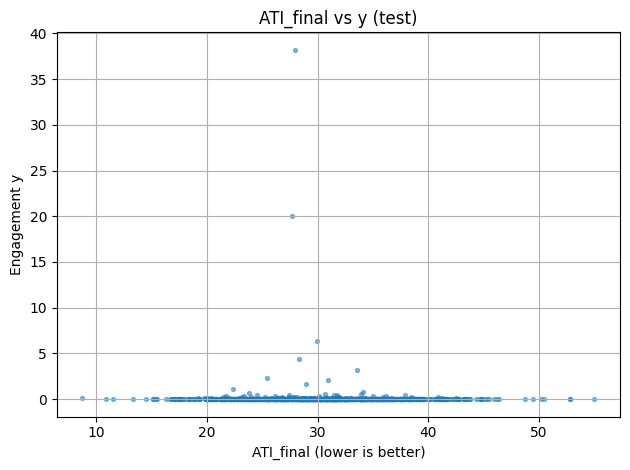

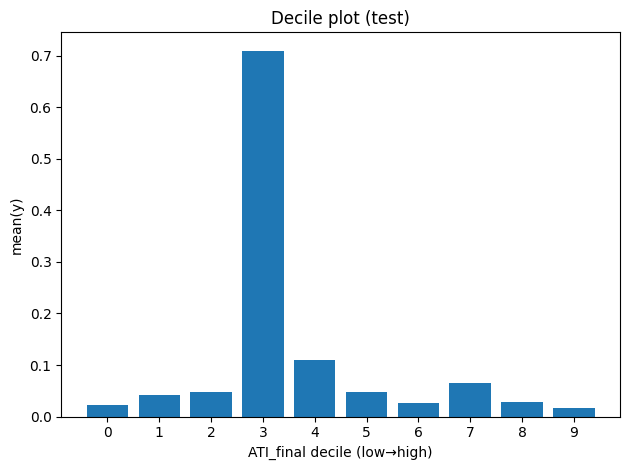

In [18]:
# (d)把關鍵圖表存檔（無 seaborn；matplotlib 單色）
import matplotlib.pyplot as plt
import numpy as np

# 1) 散點：ATI_final vs y
plt.figure()
plt.scatter(df_te['ATI_final'], df_te['y'], s=8, alpha=0.5)
plt.xlabel('ATI_final (lower is better)')
plt.ylabel('Engagement y')
plt.title('ATI_final vs y (test)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR,'outputs','plot_ati_final_vs_y.png'))

# 2) 分箱柱狀：ATI deciles vs y mean
plt.figure()
plt.bar(dec['decile'].astype(str), dec['mean'])
plt.xlabel('ATI_final decile (low→high)')
plt.ylabel('mean(y)')
plt.title('Decile plot (test)')
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR,'outputs','plot_deciles.png'))
print("Saved plots to outputs/")
